In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
sns.set(font_scale=2)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

from sklearn.decomposition import PCA

In [2]:
players = pd.io.parsers.read_csv("PlayerAttributeData.csv",low_memory=False)
players_complete = pd.io.parsers.read_csv("CompleteDataSet.csv",low_memory=False)

### Get the list of skills

In [3]:
# Get all the headers
header_labels = players.columns.values.tolist()
# Get headers without 'ID' label - this is the list of all skills
skill_labels = header_labels.copy()
skill_labels.remove('ID')
len(skill_labels)

34

### Determine the position of each player

In [4]:
positions = {'GK':['GK'], 'MID':['DM','RW','LW','LM','RM','CM','AM','CDM','CAM'],'FWD':['CF','RF','LF','ST'],'DEF':['SW','RWB','LWB','LB','RB','CB']}

In [5]:
players_complete['Position'] = players_complete['Preferred Positions'].str.split().str[0]
players_complete['Position'] = players_complete['Position'].replace(['CF','RF','LF','ST'],'FWD')
players_complete['Position'] = players_complete['Position'].replace(['SW','RWB','LWB','LB','RB','CB'],'DEF')
players_complete['Position'] = players_complete['Position'].replace(['DM','RW','LW','LM','RM','CM','AM','CDM','CAM'],'MID')

### Make a new DataFrame with skills and position

In [6]:
# Create a new DataFrame with skills and position
players_subset = players_complete[['ID','Position']].copy()
# Add all the attributes (not including ID), and convert the data to float
for label in skill_labels:
    players_subset[label] = pd.to_numeric(players_complete[label], errors='coerce')
players_subset = players_subset.replace(np.nan, 0, regex=True)
print(players_subset.shape)

(17981, 36)


In [7]:
players_skills = players_subset[skill_labels]
print(players_skills.shape)

(17981, 34)


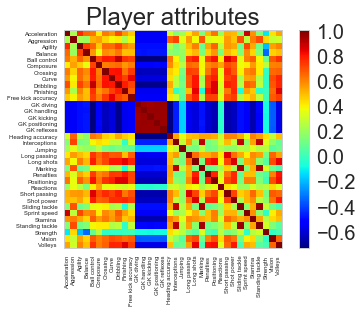

In [8]:
corr_matrix = players_skills.corr()
# plot correlation matrix
fig = plt.figure()
ax1 = fig.add_subplot(111)
cax = ax1.imshow(corr_matrix, cmap=cm.get_cmap('jet'))
plt.title('Player attributes')
plt.grid('off')
ax1.set_xticks(np.arange(players_skills.shape[1]))
ax1.set_yticks(np.arange(players_skills.shape[1]))
ax1.set_xticklabels(skill_labels,fontsize=6,rotation=90)
ax1.set_yticklabels(skill_labels,fontsize=6)
fig.colorbar(cax)

In the Heatmap chart above, X and Y Axis have a same set of the measures and each intersection shows a color that is ranging between Red and Blue. The darker the red is, the higher the positive correlation is between the two variables. The high correlation means that an increase in one variable can expect an increase in another variable in a linear fashion. And, the darker the blue is the higher the negative correlation is. The high negative correlation means that an increase in one variable can expect a decrease in another variable. If the color is green(between Red and Blue) then there is no correlation between the two variables.

Now, you would notice that there are two blue color bands that are crossing. These are all Goal Keeper (GK) related measures. And these are negatively correlated (Blue) to all the non-GK measures. So we can say that the players who score high on these measures tend to score low on the other type of measures, vice-a-versa. Goal Keepers and other position players are very different by looking at this data. And the area where these Goal Keeper related measures intersect to one another shows dark red color, which means that they are highly and positively correlated to one another.



Overall, regardless whether they are Goal Keeper related or non-Goal Keeper related there are many correlated skill measures. This means that we might not need all the skill measures, or we can express the same amount of the information with fewer set of variables.

For example, probably we just need one variable to express all those Goal Keeper related variables given that they are all highly positively correlated to one another.

### This is when we want to try PCA!

In [9]:
X = (players_skills - players_skills.mean())/players_skills.std()

U, S, Vt = np.linalg.svd(X, full_matrices=False)

variances = S**2

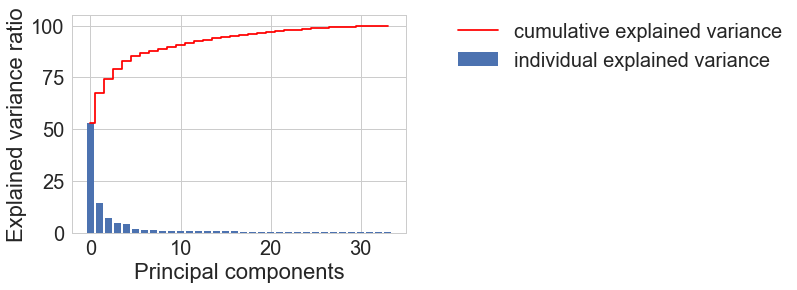

In [10]:
tot = sum(variances)
var_exp = [(i / tot)*100 for i in variances]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(len(var_exp)),var_exp, align='center', label='individual explained variance')
plt.step(range(len(var_exp)), cum_var_exp, 'r', where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [11]:
Xstar=X@Vt.T
players_subset['pc1'] = Xstar[:,0] 
players_subset['pc2'] = Xstar[:,1]

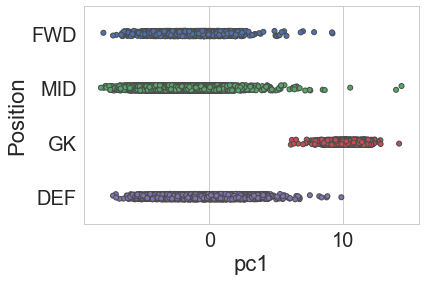

In [12]:
sns.stripplot(x="pc1",y="Position", data=players_subset, jitter=0.05, linewidth=1)

In [43]:
def plot_arrow(vector,scale,text_label):
    plt.arrow(0, 0, scale*vector[0], scale*vector[1], head_width=0.5, head_length=0.5, fc='k', ec='k', lw=1)
    plt.text(vector[0]*1.3*scale, vector[1]*1.3*scale, text_label , color='black', ha='center', va='center', fontsize=18)

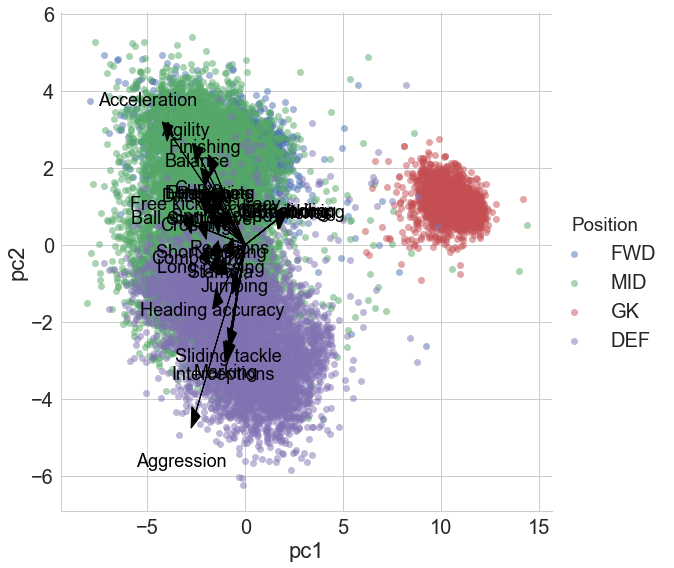

In [44]:
ax = plt.figure(figsize=(5,10))
ax = sns.lmplot('pc1', 'pc2', players_subset,hue='Position', fit_reg=False, size=8,scatter_kws={'alpha':0.5})

for i in range(30):
    label = skill_labels[i]
    plot_arrow(Vt[:,i],np.sqrt(S[i]),label)

In [34]:
/30

array([ 0.79571652,  0.57272016,  0.47701365,  0.43899116,  0.41663068,
        0.34923687,  0.32312738,  0.31441386,  0.29712442,  0.29367139,
        0.28549996,  0.2817393 ,  0.27811515,  0.27477299,  0.27240359,
        0.2673513 ,  0.2617043 ,  0.24709784,  0.24556399,  0.24364645,
        0.23780749,  0.22977404,  0.22718985,  0.22349946,  0.21954399,
        0.21823081,  0.21433114,  0.20251576,  0.19135618,  0.18232579,
        0.17759172,  0.17469285,  0.17189106,  0.16858072])